In [11]:
import pickle, os, re
from newsplease import NewsPlease
import gensim
import logging
from nltk import tokenize

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

In [7]:
articles = []

for (dirpath, dirnames, filenames) in os.walk("."):
    for filename in filenames:
        if filename.endswith(".pkl"):
            filepath = os.path.join(dirpath, filename)
            with open(filepath, 'rb') as input_file:
                e = pickle.load(input_file)
                articles.append(e)
                

In [8]:
print(articles[1].text)

Thanks to all for your suggestions for where I should visit for the magazine’s Food & Drink issue. After much consideration and brain-racking, and reading through hundreds of your e-mails and comments, I’ve decided to travel to California’s San Joaquin Valley next week; I could think of no place more exotic — or at least foreign — to which I might do a little justice in the short time I have. Many of you asked that I stay in America rather than venture abroad. The valley is the most important food center in the United States (and among the most important in the world), and it gets short shrift, largely because we tend to see it as industrial, monolithic, ugly and uninteresting. Though it has elements of all of those things (except the uninteresting), it has the opposites as well. I’m hoping to take a look at both extremes as well as the middle, through people, the land, the crops and animals, and of course through cooking.


In [12]:
## filter articles by date & length
import datetime 

start = datetime.datetime(2012, 6, 1)
end = datetime.datetime(2013, 7, 1)

filtered_articles = []

for article in articles:
    if article.date_publish is not None:
        if article.date_publish < start or article.date_publish >= end:
            continue
    if article.text is None:
        continue
    elif len(article.text.split()) <= 100:
        continue 
        
    filtered_articles.append(article)
    
articles = filtered_articles

In [14]:
import nltk
def filter_support_words(article):
        tagged = (nltk.pos_tag(nltk.word_tokenize(article)))
        filt = set(["MD","CD","IN"])
        l = [tup[0] for tup in tagged if tup[1] not in filt]
        return l
        
print (filter_support_words(articles[150].text))

['CUTTING', 'firewood', 'a', 'recent', 'afternoon', 'the', 'woods', 'the', 'back', 'our', 'farm', ',', 'it', 'occurred', 'to', 'me', 'the', 'term', 'conservative', 'has', 'lost', 'all', 'connection', 'to', 'its', 'original', 'meaning', '.', 'The', 'root', 'the', 'word', 'comes', 'the', 'Latin', 'verb', '“', 'conservare', ',', '”', 'which', 'means', '“', 'to', 'keep', 'and', 'preserve.', '”', 'It', '’', 's', 'interesting', 'the', 'origin', 'is', 'a', 'verb', 'and', 'not', 'a', 'noun', ',', 'a', 'term', 'that', 'implies', 'action', 'and', 'duty', ',', 'rather', 'merely', 'a', 'stance', '.', 'Other', 'meanings', 'suggested', 'conservative', 'have', 'to', 'do', 'frugality', ',', 'modesty', 'and', 'the', 'preservation', 'tradition', '.', 'these', 'lights', ',', 'I', 'qualify', 'a', 'conservative', '.', 'My', 'goal', 'tending', 'our', 'acres', 'is', 'to', 'preserve', 'the', 'character', 'and', 'health', 'this', 'land', '.', 'I', 'don', '’', 't', 'pile', 'chemicals', 'our', 'soil', ';', 'I', 

In [15]:
## text cleanup
import nltk
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

def prepare_text_for_lda(text):
    months = ["january","february","march","april","may","june","july","august","september","october","november","december"]
    
#     tokens = nltk.word_tokenize(text)
    tokens = filter_support_words(text)
    
    tokens = [token for token in tokens if (token).isalpha() and len(token)>2]
    tokens = [token for token in tokens if token.lower() not in stop_words]
    tokens = [token for token in tokens if token.lower() not in months]
    tokens = [get_lemma2(token) for token in tokens]
    return tokens

In [16]:
# wordcounter
from collections import Counter
from nltk import ngrams

words = [prepare_text_for_lda(article.text) for article in articles]
words = [w for bow in words for w in bow]
months = ["january","february","march","april","may","june","july","august","september","october","november","december"]

words = [word for word in words if word not in months]
ngram_counts = Counter(ngrams(words, 1))
common = ngram_counts.most_common(30)

In [17]:
# each entry is the words contained in a sentence
def break_into_articles(articles, keywords):

    document_of_articles = []
    
    i = 0
    for article in articles:
        title, date_publish, text = article.title, article.date_publish, article.text
        words = prepare_text_for_lda(text)
#         sentences = tokenize.sent_tokenize(text)
#         tokened_s = [prepare_text_for_lda(sent) for sent in sentences]

        haystack = set([s.lower() for s in words])
        needles = set([s.lower() for s in keywords])
        
        if len(haystack.intersection(needles)) > 0:
            document_of_articles.append(words)
#         art = []
#         i += 1
#         for n, sent in enumerate(tokened_s):
#             haystack = set([s.lower() for s in sent])
#             needles = set([s.lower() for s in keywords])
#             if len(haystack.intersection(needles)) > 0:
#                 art += sent
#                 document_of_articles.append(sent)
#         if len(art)>0:
#             document_of_articles.append(art)
                
    return document_of_articles

In [18]:
## break documents into tokens
obama_articles = list(break_into_articles(articles,keywords=["democrats", "democrat"]))
romney_articles = list(break_into_articles(articles,keywords=["conservative", "conservatives"]))

print (obama_articles[19])
print (len(obama_articles))

print (romney_articles[32])
print (len(romney_articles))

['editorial', 'Words', 'Spoken', 'correct', 'chide', 'Democrats', 'speaking', 'bolder', 'item', 'platform', 'However', 'give', 'sufficient', 'credit', 'even', 'item', 'ban', 'assault', 'weapon', 'sure', 'Republicans', 'wholly', 'owned', 'National', 'Rifle', 'Association', 'mention', 'plank', 'often', 'enough', 'show', 'party', 'differ', 'issue', 'Democrats', 'platform', 'verbose', 'blame', 'desire', 'include', 'Americans', 'tent', 'million', 'Americans', 'disappointed', 'President', 'Obama', 'action', 'lack', 'thereof', 'alternative', 'Republicans', 'offered', 'convinces', 'compassionate', 'Americans', 'need', 'give', 'Obama', 'year', 'THEODORE', 'VOELKER', 'New', 'York', 'Editor', 'Better', 'Answer', 'Less', 'Clear', 'news', 'article', 'question', 'misleading', 'target', 'relevant', 'question', 'better', 'John', 'McCain', 'Sarah', 'Palin', 'elected', 'better', 'year', 'Romney', 'Ryan', 'win', 'Obama', 'Biden', 'question', 'unfortunately', 'hypothetical', 'yet', 'impossible', 'answer',

In [21]:
## building documents
from gensim import corpora
from gensim.models import Phrases

# print (rejected)
doc = []
for bow in romney_articles:
    filt_words = [word for word in bow if word.lower() != "conservative" and word.lower() != "conservatives"]# if word.lower() not in rejected_new]
    doc.append(filt_words)
    
print (doc[1])

# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(doc,min_count=1,threshold=10) #min_count=5, threshold=10
trigram = Phrases(bigram[doc])

updated_docs = [bigram[doc[i]] for i in range(len(doc))]

print (updated_docs[1])

# for idx in range(len(doc)):
#     for token in bigram[doc[idx]]:
#         if '_' in token:
#             # Token is a bigram, add to document.
# #             doc[idx].append(token)
#             print (token)
#     for token in trigram[doc[idx]]:
#         if '_' in token:
#             # Token is a bigram, add to document.
# #             doc[idx].append(token)
#             print (token)
# #             print (doc[idx])
# #             print ("\n***\n")

# print (doc[2])

2018-12-22 14:33:07,160 : INFO : collecting all words and their counts
2018-12-22 14:33:07,163 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-12-22 14:33:07,281 : INFO : collected 18483 word types from a corpus of 14336 words (unigram + bigrams) and 37 sentences
2018-12-22 14:33:07,282 : INFO : using 18483 counts as vocab in Phrases<0 vocab, min_count=1, threshold=10, max_vocab_size=40000000>
2018-12-22 14:33:07,290 : INFO : collecting all words and their counts
2018-12-22 14:33:07,298 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types


['Michael', 'appreciate', 'much', 'traction', 'legalization', 'marriage', 'gained', 'look', 'Inaugural', 'Address', 'President', 'Obama', 'delivered', 'used', 'precious', 'minute', 'throw', 'spotlight', 'issue', 'make', 'support', 'clearer', 'ever', 'look', 'much', 'different', 'direction', 'world', 'professional', 'football', 'succinct', 'extraordinary', 'email', 'Brendon', 'Ayanbadejo', 'linebacker', 'Baltimore', 'Ravens', 'sent', 'hour', 'team', 'defeated', 'New', 'England', 'Patriots', 'Sunday', 'night', 'gained', 'passage', 'game', 'game', 'Super', 'Bowl', 'played', 'year', 'New', 'Orleans', 'almost', 'Monday', 'morning', 'Eastern', 'time', 'wrote', 'email', 'arrived', 'back', 'home', 'Baltimore', 'area', 'Boston', 'area', 'contest', 'taken', 'place', 'pumped', 'heart', 'bursting', 'excitement', 'Ravens', 'good', 'fortune', 'thought', 'racing', 'week', 'leading', 'Bowl', 'thought', 'turned', 'possible', 'victory', 'also', 'marriage', 'continued', 'effort', 'promote', 'team', 'head

2018-12-22 14:33:07,493 : INFO : collected 18459 word types from a corpus of 13204 words (unigram + bigrams) and 37 sentences
2018-12-22 14:33:07,495 : INFO : using 18459 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


['Michael', 'appreciate', 'much', 'traction', 'legalization_marriage', 'gained', 'look', 'Inaugural', 'Address', 'President_Obama', 'delivered', 'used', 'precious', 'minute', 'throw', 'spotlight', 'issue', 'make', 'support', 'clearer', 'ever', 'look', 'much', 'different', 'direction', 'world', 'professional_football', 'succinct', 'extraordinary', 'email', 'Brendon', 'Ayanbadejo', 'linebacker', 'Baltimore', 'Ravens', 'sent', 'hour', 'team', 'defeated', 'New_England', 'Patriots', 'Sunday_night', 'gained', 'passage', 'game', 'game', 'Super_Bowl', 'played', 'year', 'New_Orleans', 'almost', 'Monday_morning', 'Eastern', 'time', 'wrote', 'email', 'arrived', 'back', 'home', 'Baltimore', 'area', 'Boston', 'area', 'contest', 'taken', 'place', 'pumped', 'heart', 'bursting', 'excitement', 'Ravens', 'good', 'fortune', 'thought', 'racing', 'week', 'leading', 'Bowl', 'thought', 'turned', 'possible', 'victory', 'also', 'marriage', 'continued', 'effort', 'promote', 'team', 'headed', 'New_Orleans', 'spo

In [232]:
dictionary = corpora.Dictionary(updated_docs)
corpus = [dictionary.doc2bow(text) for text in updated_docs]

# dictionary.filter_extremes(no_above=0.01) #no below int, no above float, keep_n (int) – Keep only the first keep_n most frequent tokens.
# import pickle
# pickle.dump(corpus, open('corpus.pkl', 'wb'))
# dictionary.save('dictionary.gensim

2018-12-21 15:06:57,109 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-12-21 15:06:57,143 : INFO : built Dictionary(5353 unique tokens: ['ABC', 'Adam', 'Delaware', 'Democratic', 'Elaine']...) from 37 documents (total 13204 corpus positions)


In [212]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
#         coherence_values.append(ldamodel.log_perplexity(corpus))
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [233]:
start=2
limit=40
step=3
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=updated_docs, start=start, limit=limit, step=step)


2018-12-21 15:07:09,479 : INFO : using symmetric alpha at 0.5
2018-12-21 15:07:09,483 : INFO : using symmetric eta at 0.5
2018-12-21 15:07:09,490 : INFO : using serial LDA version on this node
2018-12-21 15:07:09,497 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 37 documents, updating model once every 37 documents, evaluating perplexity every 37 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-21 15:07:09,499 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2018-12-21 15:07:09,717 : INFO : -9.192 per-word bound, 584.9 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:07:09,719 : INFO : PROGRESS: pass 0, at document #37/37
2018-12-21 15:07:09,829 : INFO : topic #0 (0.500): 0.004*"party" + 0.003*"said" + 0.003*"Republicans" + 0.003*"Republican" + 0.003*"Obama" + 0.003*"Romney" + 0.003*

2018-12-21 15:07:14,383 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2018-12-21 15:07:14,540 : INFO : -14.476 per-word bound, 22790.0 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:07:14,541 : INFO : PROGRESS: pass 0, at document #37/37
2018-12-21 15:07:14,635 : INFO : topic #3 (0.091): 0.003*"year" + 0.002*"right" + 0.002*"Romney" + 0.002*"policy" + 0.002*"party" + 0.002*"time" + 0.002*"cost" + 0.002*"even" + 0.002*"also" + 0.002*"Ayanbadejo"
2018-12-21 15:07:14,636 : INFO : topic #9 (0.091): 0.003*"right" + 0.003*"Obama" + 0.003*"said" + 0.003*"policy" + 0.003*"time" + 0.003*"make" + 0.002*"people" + 0.002*"party" + 0.002*"government" + 0.002*"Romney"
2018-12-21 15:07:14,637 : INFO : topic #4 (0.091): 0.004*"Romney" + 0.004*"Forbes" + 0.003*"Obama" + 0.003*"Republicans" + 0.003*"Republican" + 0.003*"political" + 0.002*"party" + 0.002*"people" + 0.002*

2018-12-21 15:07:19,987 : INFO : using symmetric eta at 0.05
2018-12-21 15:07:19,989 : INFO : using serial LDA version on this node
2018-12-21 15:07:20,008 : INFO : running online (single-pass) LDA training, 20 topics, 1 passes over the supplied corpus of 37 documents, updating model once every 37 documents, evaluating perplexity every 37 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-21 15:07:20,009 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2018-12-21 15:07:20,177 : INFO : -22.633 per-word bound, 6505248.7 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:07:20,178 : INFO : PROGRESS: pass 0, at document #37/37
2018-12-21 15:07:20,261 : INFO : topic #12 (0.050): 0.004*"party" + 0.004*"said" + 0.003*"marriage" + 0.002*"system" + 0.002*"Republicans" + 0.002*"voter" + 0.002*"many" + 0.002*"government" + 0.002*"way" + 0.002*"Repub

2018-12-21 15:07:26,494 : INFO : serializing accumulator to return to master...
2018-12-21 15:07:26,500 : INFO : accumulator serialized
2018-12-21 15:07:26,589 : INFO : 3 accumulators retrieved from output queue
2018-12-21 15:07:26,628 : INFO : accumulated word occurrence stats for 9171 virtual documents
2018-12-21 15:07:28,481 : INFO : using symmetric alpha at 0.034482758620689655
2018-12-21 15:07:28,483 : INFO : using symmetric eta at 0.034482758620689655
2018-12-21 15:07:28,492 : INFO : using serial LDA version on this node
2018-12-21 15:07:28,531 : INFO : running online (single-pass) LDA training, 29 topics, 1 passes over the supplied corpus of 37 documents, updating model once every 37 documents, evaluating perplexity every 37 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-21 15:07:28,537 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2018-12-21 15:07:28,758 : INFO : -3

2018-12-21 15:07:35,750 : INFO : 1 batches submitted to accumulate stats from 64 documents (9171 virtual)
2018-12-21 15:07:35,759 : INFO : serializing accumulator to return to master...
2018-12-21 15:07:35,759 : INFO : serializing accumulator to return to master...
2018-12-21 15:07:35,773 : INFO : accumulator serialized
2018-12-21 15:07:35,773 : INFO : accumulator serialized
2018-12-21 15:07:36,487 : INFO : serializing accumulator to return to master...
2018-12-21 15:07:36,493 : INFO : accumulator serialized
2018-12-21 15:07:36,618 : INFO : 3 accumulators retrieved from output queue
2018-12-21 15:07:36,663 : INFO : accumulated word occurrence stats for 9171 virtual documents
2018-12-21 15:07:38,761 : INFO : using symmetric alpha at 0.02631578947368421
2018-12-21 15:07:38,782 : INFO : using symmetric eta at 0.02631578947368421
2018-12-21 15:07:38,786 : INFO : using serial LDA version on this node
2018-12-21 15:07:38,860 : INFO : running online (single-pass) LDA training, 38 topics, 1 pa

2 0.248884127465403
5 0.2706335792369589
8 0.25887627452448064
11 0.26172003660504906
14 0.26987451097641063
17 0.2894385064459153
20 0.296138822758275
23 0.29495694215257656
26 0.30746250687574395
29 0.30696577126916774
32 0.2742056424048477
35 0.28660041751463067
38 0.30816656591076


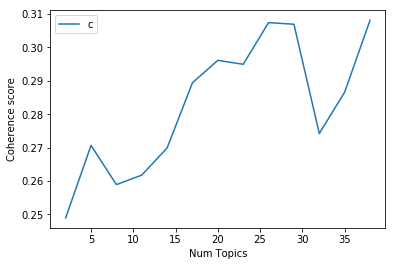

In [234]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)


for i, c in enumerate(coherence_values):
    print (x[i], c)


plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [238]:
# generate topic model
import gensim

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

NUM_TOPICS =20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=200)
# ldamodel.save('model5.gensim')


2018-12-21 15:13:14,191 : INFO : using symmetric alpha at 0.05
2018-12-21 15:13:14,200 : INFO : using symmetric eta at 0.05
2018-12-21 15:13:14,205 : INFO : using serial LDA version on this node
2018-12-21 15:13:14,238 : INFO : running online (multi-pass) LDA training, 20 topics, 200 passes over the supplied corpus of 37 documents, updating model once every 37 documents, evaluating perplexity every 37 documents, iterating 50x with a convergence threshold of 0.001000
2018-12-21 15:13:14,619 : INFO : -22.634 per-word bound, 6509977.5 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:14,632 : INFO : PROGRESS: pass 0, at document #37/37
2018-12-21 15:13:14,786 : INFO : topic #6 (0.050): 0.005*"Republicans" + 0.004*"Obama" + 0.004*"Romney" + 0.003*"policy" + 0.003*"party" + 0.002*"benefit" + 0.002*"people" + 0.002*"support" + 0.002*"right" + 0.002*"government"
2018-12-21 15:13:14,788 : INFO : topic #15 (0.050): 0.004*"said" + 0.003*"Ayanbadejo"

2018-12-21 15:13:15,985 : INFO : topic #9 (0.050): 0.009*"Republicans" + 0.008*"party" + 0.006*"government" + 0.005*"issue" + 0.005*"political" + 0.005*"Republican" + 0.005*"country" + 0.005*"policy" + 0.004*"economic" + 0.004*"vote"
2018-12-21 15:13:15,988 : INFO : topic #2 (0.050): 0.017*"court" + 0.009*"employer" + 0.009*"federal" + 0.007*"right" + 0.007*"notice" + 0.005*"way" + 0.005*"issue" + 0.005*"good" + 0.005*"subject" + 0.005*"rule"
2018-12-21 15:13:15,991 : INFO : topic #15 (0.050): 0.014*"Ayanbadejo" + 0.007*"email" + 0.007*"Super_Bowl" + 0.006*"said" + 0.005*"group" + 0.005*"also" + 0.005*"told" + 0.004*"time" + 0.004*"owner" + 0.004*"player"
2018-12-21 15:13:15,993 : INFO : topic diff=0.563477, rho=0.377964
2018-12-21 15:13:16,157 : INFO : -8.709 per-word bound, 418.4 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:16,159 : INFO : PROGRESS: pass 6, at document #37/37
2018-12-21 15:13:16,283 : INFO : topic #7 (0.050): 0.008*

2018-12-21 15:13:17,430 : INFO : topic #0 (0.050): 0.014*"said" + 0.013*"Verrilli" + 0.009*"lawyer" + 0.008*"case" + 0.007*"government" + 0.006*"argument" + 0.006*"Supreme_Court" + 0.005*"administration" + 0.004*"health_care" + 0.004*"brief"
2018-12-21 15:13:17,436 : INFO : topic #14 (0.050): 0.018*"trial" + 0.007*"murder" + 0.007*"attention" + 0.007*"coverage" + 0.007*"piece" + 0.007*"medium" + 0.007*"abortion" + 0.007*"Friday" + 0.005*"Times" + 0.005*"wrote"
2018-12-21 15:13:17,439 : INFO : topic #4 (0.050): 0.007*"Romney" + 0.005*"Obama" + 0.005*"party" + 0.005*"America" + 0.005*"candidate" + 0.005*"run" + 0.005*"Bush" + 0.005*"Medicare" + 0.005*"demand" + 0.003*"way"
2018-12-21 15:13:17,441 : INFO : topic #18 (0.050): 0.009*"cost" + 0.009*"health_care" + 0.006*"care" + 0.006*"insurance" + 0.005*"even" + 0.005*"campaign" + 0.005*"Douthat" + 0.005*"health_insurance" + 0.004*"people" + 0.004*"fact"
2018-12-21 15:13:17,444 : INFO : topic diff=0.063089, rho=0.277350
2018-12-21 15:13:17,

2018-12-21 15:13:18,548 : INFO : PROGRESS: pass 17, at document #37/37
2018-12-21 15:13:18,603 : INFO : topic #17 (0.050): 0.006*"education" + 0.006*"student" + 0.005*"populist" + 0.005*"Dewey" + 0.005*"country" + 0.004*"Erickson" + 0.004*"school" + 0.004*"leader" + 0.004*"north" + 0.004*"party"
2018-12-21 15:13:18,608 : INFO : topic #1 (0.050): 0.007*"Obama" + 0.006*"voter" + 0.006*"marriage" + 0.005*"poll" + 0.005*"percent" + 0.005*"policy" + 0.005*"convention" + 0.004*"benefit" + 0.004*"way" + 0.004*"used"
2018-12-21 15:13:18,611 : INFO : topic #2 (0.050): 0.017*"court" + 0.010*"employer" + 0.010*"federal" + 0.007*"right" + 0.007*"notice" + 0.005*"way" + 0.005*"issue" + 0.005*"good" + 0.005*"subject" + 0.005*"rule"
2018-12-21 15:13:18,613 : INFO : topic #3 (0.050): 0.019*"Obama" + 0.009*"president" + 0.007*"victory" + 0.007*"American" + 0.007*"Reagan" + 0.007*"philosophical" + 0.005*"government" + 0.005*"come" + 0.005*"still" + 0.005*"rather"
2018-12-21 15:13:18,615 : INFO : topic #

2018-12-21 15:13:19,501 : INFO : topic diff=0.003055, rho=0.204124
2018-12-21 15:13:19,637 : INFO : -8.620 per-word bound, 393.6 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:19,638 : INFO : PROGRESS: pass 23, at document #37/37
2018-12-21 15:13:19,691 : INFO : topic #6 (0.050): 0.000*"Republicans" + 0.000*"Obama" + 0.000*"Romney" + 0.000*"policy" + 0.000*"party" + 0.000*"benefit" + 0.000*"people" + 0.000*"support" + 0.000*"right" + 0.000*"Republican"
2018-12-21 15:13:19,694 : INFO : topic #13 (0.050): 0.000*"Ayanbadejo" + 0.000*"case" + 0.000*"said" + 0.000*"time" + 0.000*"wrote" + 0.000*"Super_Bowl" + 0.000*"week" + 0.000*"also" + 0.000*"support" + 0.000*"Ravens"
2018-12-21 15:13:19,696 : INFO : topic #8 (0.050): 0.008*"Republicans" + 0.007*"party" + 0.007*"Europe" + 0.004*"term" + 0.004*"autocomplete" + 0.004*"immigration_reform" + 0.004*"world" + 0.004*"Silicon_Valley" + 0.004*"Google" + 0.004*"algorithm"
2018-12-21 15:13:19,698 : 

2018-12-21 15:13:21,079 : INFO : topic #19 (0.050): 0.015*"Paul" + 0.010*"party" + 0.009*"foreign_policy" + 0.006*"libertarian" + 0.006*"filibuster" + 0.006*"policy" + 0.005*"Republicans" + 0.005*"president" + 0.005*"idea" + 0.005*"support"
2018-12-21 15:13:21,085 : INFO : topic diff=0.000861, rho=0.182574
2018-12-21 15:13:21,501 : INFO : -8.620 per-word bound, 393.5 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:21,503 : INFO : PROGRESS: pass 29, at document #37/37
2018-12-21 15:13:21,622 : INFO : topic #16 (0.050): 0.014*"Silver" + 0.009*"said" + 0.008*"voter" + 0.008*"Republican" + 0.006*"Scarborough" + 0.006*"Times" + 0.006*"party" + 0.006*"Representative" + 0.005*"poll" + 0.005*"Republicans"
2018-12-21 15:13:21,624 : INFO : topic #3 (0.050): 0.019*"Obama" + 0.009*"president" + 0.007*"victory" + 0.007*"American" + 0.007*"Reagan" + 0.007*"philosophical" + 0.005*"government" + 0.005*"come" + 0.005*"still" + 0.005*"rather"
2018-12-21 1

2018-12-21 15:13:23,712 : INFO : topic #15 (0.050): 0.015*"Ayanbadejo" + 0.007*"email" + 0.007*"Super_Bowl" + 0.007*"group" + 0.006*"said" + 0.006*"told" + 0.005*"also" + 0.005*"time" + 0.005*"owner" + 0.005*"player"
2018-12-21 15:13:23,714 : INFO : topic #6 (0.050): 0.000*"Republicans" + 0.000*"Obama" + 0.000*"Romney" + 0.000*"policy" + 0.000*"party" + 0.000*"benefit" + 0.000*"people" + 0.000*"support" + 0.000*"right" + 0.000*"Republican"
2018-12-21 15:13:23,719 : INFO : topic diff=0.000303, rho=0.166667
2018-12-21 15:13:23,877 : INFO : -8.620 per-word bound, 393.4 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:23,878 : INFO : PROGRESS: pass 35, at document #37/37
2018-12-21 15:13:23,933 : INFO : topic #11 (0.050): 0.009*"Republican" + 0.009*"DISTRICT_part" + 0.009*"race" + 0.009*"State_Senator" + 0.009*"STATE_SENATE" + 0.007*"voted" + 0.007*"Saland" + 0.006*"Democratic" + 0.006*"party" + 0.006*"Albany"
2018-12-21 15:13:23,936 : INFO :

2018-12-21 15:13:26,170 : INFO : topic #11 (0.050): 0.009*"Republican" + 0.009*"DISTRICT_part" + 0.009*"race" + 0.009*"State_Senator" + 0.009*"STATE_SENATE" + 0.007*"Saland" + 0.007*"voted" + 0.006*"Democratic" + 0.006*"party" + 0.006*"Albany"
2018-12-21 15:13:26,176 : INFO : topic #1 (0.050): 0.007*"Obama" + 0.006*"voter" + 0.006*"marriage" + 0.005*"poll" + 0.005*"percent" + 0.005*"policy" + 0.005*"convention" + 0.004*"benefit" + 0.004*"way" + 0.004*"used"
2018-12-21 15:13:26,178 : INFO : topic #9 (0.050): 0.009*"Republicans" + 0.008*"party" + 0.006*"government" + 0.006*"issue" + 0.006*"political" + 0.006*"Republican" + 0.005*"country" + 0.005*"economic" + 0.004*"think" + 0.004*"people"
2018-12-21 15:13:26,180 : INFO : topic diff=0.000131, rho=0.154303
2018-12-21 15:13:26,293 : INFO : -8.620 per-word bound, 393.4 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:26,294 : INFO : PROGRESS: pass 41, at document #37/37
2018-12-21 15:13:26,330

2018-12-21 15:13:27,957 : INFO : topic #9 (0.050): 0.009*"Republicans" + 0.008*"party" + 0.006*"government" + 0.006*"issue" + 0.006*"political" + 0.006*"Republican" + 0.005*"country" + 0.005*"economic" + 0.004*"think" + 0.004*"people"
2018-12-21 15:13:27,959 : INFO : topic #14 (0.050): 0.018*"trial" + 0.007*"murder" + 0.007*"attention" + 0.007*"piece" + 0.007*"coverage" + 0.007*"medium" + 0.007*"abortion" + 0.007*"Friday" + 0.005*"Times" + 0.005*"wrote"
2018-12-21 15:13:27,962 : INFO : topic #16 (0.050): 0.014*"Silver" + 0.009*"said" + 0.008*"Republican" + 0.008*"voter" + 0.006*"Scarborough" + 0.006*"Times" + 0.006*"party" + 0.006*"Representative" + 0.005*"poll" + 0.005*"Republicans"
2018-12-21 15:13:27,964 : INFO : topic #3 (0.050): 0.019*"Obama" + 0.009*"president" + 0.007*"victory" + 0.007*"American" + 0.007*"Reagan" + 0.007*"philosophical" + 0.005*"government" + 0.005*"come" + 0.005*"still" + 0.005*"seems"
2018-12-21 15:13:27,966 : INFO : topic diff=0.000072, rho=0.144338
2018-12-2

2018-12-21 15:13:28,822 : INFO : PROGRESS: pass 52, at document #37/37
2018-12-21 15:13:28,853 : INFO : topic #7 (0.050): 0.008*"Obama" + 0.007*"system" + 0.006*"candidate" + 0.006*"year" + 0.005*"money" + 0.004*"raise" + 0.004*"way" + 0.004*"many" + 0.004*"policy" + 0.003*"party"
2018-12-21 15:13:28,854 : INFO : topic #14 (0.050): 0.018*"trial" + 0.007*"murder" + 0.007*"attention" + 0.007*"coverage" + 0.007*"piece" + 0.007*"medium" + 0.007*"abortion" + 0.007*"Friday" + 0.005*"Times" + 0.005*"wrote"
2018-12-21 15:13:28,856 : INFO : topic #2 (0.050): 0.017*"court" + 0.010*"federal" + 0.010*"employer" + 0.007*"right" + 0.007*"notice" + 0.005*"way" + 0.005*"trial_court" + 0.005*"subject" + 0.005*"good" + 0.005*"rule"
2018-12-21 15:13:28,860 : INFO : topic #10 (0.050): 0.031*"Times" + 0.007*"reporting" + 0.007*"reader" + 0.007*"wrote" + 0.007*"coverage" + 0.005*"circulation" + 0.005*"subscription" + 0.005*"print" + 0.005*"editor" + 0.005*"paper"
2018-12-21 15:13:28,863 : INFO : topic #3 (0

2018-12-21 15:13:29,887 : INFO : topic diff=0.000056, rho=0.130189
2018-12-21 15:13:30,034 : INFO : -8.619 per-word bound, 393.3 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:30,035 : INFO : PROGRESS: pass 58, at document #37/37
2018-12-21 15:13:30,093 : INFO : topic #15 (0.050): 0.015*"Ayanbadejo" + 0.007*"email" + 0.007*"Super_Bowl" + 0.007*"group" + 0.006*"said" + 0.006*"told" + 0.005*"also" + 0.005*"player" + 0.005*"owner" + 0.005*"time"
2018-12-21 15:13:30,096 : INFO : topic #10 (0.050): 0.031*"Times" + 0.007*"reporting" + 0.007*"reader" + 0.007*"wrote" + 0.007*"coverage" + 0.005*"circulation" + 0.005*"subscription" + 0.005*"print" + 0.005*"editor" + 0.005*"paper"
2018-12-21 15:13:30,098 : INFO : topic #3 (0.050): 0.019*"Obama" + 0.009*"president" + 0.007*"victory" + 0.007*"American" + 0.007*"Reagan" + 0.007*"philosophical" + 0.005*"come" + 0.005*"still" + 0.005*"government" + 0.005*"sense"
2018-12-21 15:13:30,109 : INFO : topic #

2018-12-21 15:13:32,348 : INFO : topic #0 (0.050): 0.014*"said" + 0.014*"Verrilli" + 0.009*"lawyer" + 0.008*"case" + 0.007*"government" + 0.006*"argument" + 0.006*"Supreme_Court" + 0.005*"administration" + 0.004*"brief" + 0.004*"health_care"
2018-12-21 15:13:32,351 : INFO : topic diff=0.000062, rho=0.124035
2018-12-21 15:13:32,691 : INFO : -8.619 per-word bound, 393.2 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:32,693 : INFO : PROGRESS: pass 64, at document #37/37
2018-12-21 15:13:32,771 : INFO : topic #17 (0.050): 0.006*"education" + 0.006*"student" + 0.005*"country" + 0.005*"Dewey" + 0.005*"populist" + 0.004*"Erickson" + 0.004*"school" + 0.004*"leader" + 0.004*"north" + 0.004*"party"
2018-12-21 15:13:32,774 : INFO : topic #3 (0.050): 0.019*"Obama" + 0.009*"president" + 0.007*"victory" + 0.007*"American" + 0.007*"Reagan" + 0.007*"philosophical" + 0.005*"still" + 0.005*"come" + 0.005*"government" + 0.005*"sense"
2018-12-21 15:13:32,7

2018-12-21 15:13:34,173 : INFO : topic #8 (0.050): 0.008*"Republicans" + 0.007*"party" + 0.007*"Europe" + 0.004*"term" + 0.004*"autocomplete" + 0.004*"immigration_reform" + 0.004*"Google" + 0.004*"algorithm" + 0.004*"Silicon_Valley" + 0.004*"world"
2018-12-21 15:13:34,175 : INFO : topic #9 (0.050): 0.009*"Republicans" + 0.008*"party" + 0.006*"government" + 0.006*"issue" + 0.006*"political" + 0.006*"Republican" + 0.005*"country" + 0.005*"economic" + 0.005*"think" + 0.004*"people"
2018-12-21 15:13:34,179 : INFO : topic diff=0.000065, rho=0.118678
2018-12-21 15:13:34,339 : INFO : -8.619 per-word bound, 393.2 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:34,340 : INFO : PROGRESS: pass 70, at document #37/37
2018-12-21 15:13:34,408 : INFO : topic #6 (0.050): 0.000*"Republicans" + 0.000*"Obama" + 0.000*"Romney" + 0.000*"policy" + 0.000*"party" + 0.000*"benefit" + 0.000*"people" + 0.000*"Republican" + 0.000*"right" + 0.000*"government"
2018-1

2018-12-21 15:13:35,639 : INFO : topic #19 (0.050): 0.015*"Paul" + 0.010*"party" + 0.009*"foreign_policy" + 0.006*"filibuster" + 0.006*"libertarian" + 0.006*"policy" + 0.005*"sometimes" + 0.005*"something" + 0.005*"delivered" + 0.005*"president"
2018-12-21 15:13:35,641 : INFO : topic #18 (0.050): 0.009*"health_care" + 0.009*"cost" + 0.006*"insurance" + 0.006*"care" + 0.005*"even" + 0.005*"campaign" + 0.005*"Douthat" + 0.005*"health_insurance" + 0.004*"people" + 0.004*"physician"
2018-12-21 15:13:35,644 : INFO : topic #16 (0.050): 0.014*"Silver" + 0.009*"said" + 0.008*"Republican" + 0.008*"voter" + 0.006*"Scarborough" + 0.006*"party" + 0.006*"Times" + 0.006*"Representative" + 0.005*"poll" + 0.005*"Republicans"
2018-12-21 15:13:35,647 : INFO : topic diff=0.000060, rho=0.113961
2018-12-21 15:13:35,800 : INFO : -8.619 per-word bound, 393.1 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:35,804 : INFO : PROGRESS: pass 76, at document #37/37
2

2018-12-21 15:13:37,941 : INFO : topic #9 (0.050): 0.009*"Republicans" + 0.008*"party" + 0.006*"government" + 0.006*"issue" + 0.006*"political" + 0.006*"Republican" + 0.005*"country" + 0.005*"economic" + 0.005*"think" + 0.004*"people"
2018-12-21 15:13:37,944 : INFO : topic #4 (0.050): 0.007*"Romney" + 0.005*"Obama" + 0.005*"run" + 0.005*"America" + 0.005*"Medicare" + 0.005*"party" + 0.005*"Bush" + 0.005*"candidate" + 0.005*"demand" + 0.003*"Republicans"
2018-12-21 15:13:37,946 : INFO : topic #17 (0.050): 0.006*"education" + 0.006*"student" + 0.005*"country" + 0.005*"populist" + 0.005*"Dewey" + 0.004*"school" + 0.004*"Erickson" + 0.004*"leader" + 0.004*"north" + 0.004*"post"
2018-12-21 15:13:37,950 : INFO : topic #13 (0.050): 0.000*"Ayanbadejo" + 0.000*"case" + 0.000*"said" + 0.000*"time" + 0.000*"wrote" + 0.000*"Super_Bowl" + 0.000*"week" + 0.000*"also" + 0.000*"Ravens" + 0.000*"support"
2018-12-21 15:13:37,955 : INFO : topic diff=0.000050, rho=0.109764
2018-12-21 15:13:38,180 : INFO :

2018-12-21 15:13:39,283 : INFO : topic #19 (0.050): 0.015*"Paul" + 0.010*"party" + 0.009*"foreign_policy" + 0.006*"libertarian" + 0.006*"filibuster" + 0.006*"policy" + 0.005*"president" + 0.005*"lesson" + 0.005*"delivered" + 0.005*"idea"
2018-12-21 15:13:39,285 : INFO : topic #10 (0.050): 0.031*"Times" + 0.007*"reader" + 0.007*"reporting" + 0.007*"wrote" + 0.007*"coverage" + 0.005*"subscription" + 0.005*"circulation" + 0.005*"print" + 0.005*"editor" + 0.005*"paper"
2018-12-21 15:13:39,287 : INFO : topic #12 (0.050): 0.016*"Brooks" + 0.014*"Romney" + 0.013*"Editor_David" + 0.011*"President_Obama" + 0.005*"Mitt_Romney" + 0.005*"govern" + 0.005*"Congress" + 0.004*"country" + 0.004*"Supreme_Court" + 0.004*"second_term"
2018-12-21 15:13:39,290 : INFO : topic #6 (0.050): 0.000*"Republicans" + 0.000*"Obama" + 0.000*"Romney" + 0.000*"policy" + 0.000*"party" + 0.000*"benefit" + 0.000*"support" + 0.000*"Republican" + 0.000*"right" + 0.000*"government"
2018-12-21 15:13:39,304 : INFO : topic #5 (0

2018-12-21 15:13:40,571 : INFO : topic diff=0.000031, rho=0.103142
2018-12-21 15:13:40,747 : INFO : -8.619 per-word bound, 393.1 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:40,750 : INFO : PROGRESS: pass 93, at document #37/37
2018-12-21 15:13:40,821 : INFO : topic #11 (0.050): 0.009*"Republican" + 0.009*"race" + 0.009*"STATE_SENATE" + 0.009*"DISTRICT_part" + 0.009*"State_Senator" + 0.007*"Saland" + 0.007*"voted" + 0.006*"Democratic" + 0.006*"endorse" + 0.006*"lawmaker"
2018-12-21 15:13:40,824 : INFO : topic #6 (0.050): 0.000*"Republicans" + 0.000*"Obama" + 0.000*"Romney" + 0.000*"policy" + 0.000*"party" + 0.000*"benefit" + 0.000*"health_care" + 0.000*"plan" + 0.000*"right" + 0.000*"political"
2018-12-21 15:13:40,827 : INFO : topic #15 (0.050): 0.015*"Ayanbadejo" + 0.007*"Super_Bowl" + 0.007*"email" + 0.007*"group" + 0.006*"said" + 0.006*"told" + 0.005*"also" + 0.005*"time" + 0.005*"owner" + 0.005*"player"
2018-12-21 15:13:40,834 : I

2018-12-21 15:13:42,339 : INFO : topic #17 (0.050): 0.006*"education" + 0.006*"student" + 0.005*"country" + 0.005*"Dewey" + 0.005*"populist" + 0.004*"Erickson" + 0.004*"north" + 0.004*"school" + 0.004*"leader" + 0.004*"Mali"
2018-12-21 15:13:42,341 : INFO : topic #19 (0.050): 0.015*"Paul" + 0.010*"party" + 0.009*"foreign_policy" + 0.006*"libertarian" + 0.006*"filibuster" + 0.006*"policy" + 0.005*"Iraq" + 0.005*"sometimes" + 0.005*"something" + 0.005*"well"
2018-12-21 15:13:42,347 : INFO : topic diff=0.000024, rho=0.100000
2018-12-21 15:13:42,548 : INFO : -8.619 per-word bound, 393.1 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:42,550 : INFO : PROGRESS: pass 99, at document #37/37
2018-12-21 15:13:42,639 : INFO : topic #5 (0.050): 0.013*"Forbes" + 0.012*"capital_gain" + 0.012*"Heritage" + 0.007*"list" + 0.007*"report" + 0.005*"wealth" + 0.005*"economist" + 0.005*"Rector" + 0.005*"cost" + 0.005*"rate"
2018-12-21 15:13:42,641 : INFO : to

2018-12-21 15:13:44,245 : INFO : topic #16 (0.050): 0.014*"Silver" + 0.009*"said" + 0.008*"Republican" + 0.008*"voter" + 0.006*"Scarborough" + 0.006*"party" + 0.006*"Times" + 0.006*"Representative" + 0.005*"Republicans" + 0.005*"Senator"
2018-12-21 15:13:44,247 : INFO : topic #2 (0.050): 0.017*"court" + 0.010*"federal" + 0.010*"employer" + 0.007*"notice" + 0.007*"right" + 0.005*"way" + 0.005*"issue" + 0.005*"rule" + 0.005*"subject" + 0.005*"good"
2018-12-21 15:13:44,249 : INFO : topic #11 (0.050): 0.009*"Republican" + 0.009*"STATE_SENATE" + 0.009*"race" + 0.009*"State_Senator" + 0.009*"DISTRICT_part" + 0.007*"Saland" + 0.007*"voted" + 0.006*"Democratic" + 0.006*"right" + 0.006*"Albany"
2018-12-21 15:13:44,251 : INFO : topic #12 (0.050): 0.016*"Brooks" + 0.014*"Romney" + 0.013*"Editor_David" + 0.011*"President_Obama" + 0.005*"govern" + 0.005*"Congress" + 0.005*"Mitt_Romney" + 0.004*"country" + 0.004*"threat" + 0.004*"House"
2018-12-21 15:13:44,258 : INFO : topic diff=0.000018, rho=0.097

2018-12-21 15:13:45,929 : INFO : PROGRESS: pass 110, at document #37/37
2018-12-21 15:13:45,974 : INFO : topic #4 (0.050): 0.007*"Romney" + 0.005*"Obama" + 0.005*"Medicare" + 0.005*"party" + 0.005*"Bush" + 0.005*"America" + 0.005*"candidate" + 0.005*"run" + 0.005*"demand" + 0.003*"right"
2018-12-21 15:13:45,979 : INFO : topic #5 (0.050): 0.013*"Forbes" + 0.012*"Heritage" + 0.012*"capital_gain" + 0.007*"list" + 0.007*"report" + 0.005*"wealth" + 0.005*"economist" + 0.005*"immigrant" + 0.005*"cost" + 0.005*"percent"
2018-12-21 15:13:45,981 : INFO : topic #8 (0.050): 0.008*"Republicans" + 0.007*"party" + 0.007*"Europe" + 0.004*"autocomplete" + 0.004*"term" + 0.004*"immigration_reform" + 0.004*"algorithm" + 0.004*"world" + 0.004*"Silicon_Valley" + 0.004*"Google"
2018-12-21 15:13:45,985 : INFO : topic #7 (0.050): 0.008*"Obama" + 0.007*"system" + 0.006*"candidate" + 0.006*"year" + 0.005*"money" + 0.004*"raise" + 0.004*"way" + 0.004*"many" + 0.004*"policy" + 0.003*"party"
2018-12-21 15:13:45,9

2018-12-21 15:13:47,020 : INFO : topic #11 (0.050): 0.009*"Republican" + 0.009*"race" + 0.009*"DISTRICT_part" + 0.009*"STATE_SENATE" + 0.009*"State_Senator" + 0.007*"Saland" + 0.007*"voted" + 0.006*"Democratic" + 0.006*"party" + 0.006*"Albany"
2018-12-21 15:13:47,023 : INFO : topic diff=0.000009, rho=0.092450
2018-12-21 15:13:47,159 : INFO : -8.619 per-word bound, 393.1 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:47,160 : INFO : PROGRESS: pass 116, at document #37/37
2018-12-21 15:13:47,219 : INFO : topic #6 (0.050): 0.000*"Republicans" + 0.000*"language_market" + 0.000*"intrudes" + 0.000*"mobility" + 0.000*"mentality" + 0.000*"make_sense" + 0.000*"lowly" + 0.000*"linked" + 0.000*"layer" + 0.000*"nestled"
2018-12-21 15:13:47,221 : INFO : topic #5 (0.050): 0.013*"Forbes" + 0.012*"capital_gain" + 0.012*"Heritage" + 0.007*"list" + 0.007*"report" + 0.005*"percent" + 0.005*"Rector" + 0.005*"wealth" + 0.005*"immigrant" + 0.005*"economist"


2018-12-21 15:13:48,404 : INFO : topic #19 (0.050): 0.015*"Paul" + 0.010*"party" + 0.009*"foreign_policy" + 0.006*"filibuster" + 0.006*"libertarian" + 0.006*"policy" + 0.005*"lesson" + 0.005*"Republican_Party" + 0.005*"idea" + 0.005*"president"
2018-12-21 15:13:48,407 : INFO : topic #4 (0.050): 0.007*"Romney" + 0.005*"Obama" + 0.005*"candidate" + 0.005*"run" + 0.005*"America" + 0.005*"Bush" + 0.005*"party" + 0.005*"Medicare" + 0.005*"demand" + 0.003*"way"
2018-12-21 15:13:48,413 : INFO : topic diff=0.000006, rho=0.090167
2018-12-21 15:13:48,551 : INFO : -8.619 per-word bound, 393.1 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:48,553 : INFO : PROGRESS: pass 122, at document #37/37
2018-12-21 15:13:48,608 : INFO : topic #0 (0.050): 0.014*"said" + 0.014*"Verrilli" + 0.009*"lawyer" + 0.008*"case" + 0.007*"government" + 0.006*"argument" + 0.006*"Supreme_Court" + 0.005*"administration" + 0.004*"justice" + 0.004*"court"
2018-12-21 15:13:48,6

2018-12-21 15:13:49,974 : INFO : topic #16 (0.050): 0.014*"Silver" + 0.009*"said" + 0.008*"Republican" + 0.008*"voter" + 0.006*"Scarborough" + 0.006*"Times" + 0.006*"party" + 0.006*"Representative" + 0.005*"Senator" + 0.005*"Republicans"
2018-12-21 15:13:49,981 : INFO : topic #2 (0.050): 0.017*"court" + 0.010*"federal" + 0.010*"employer" + 0.007*"right" + 0.007*"notice" + 0.005*"way" + 0.005*"authority" + 0.005*"good" + 0.005*"issue" + 0.005*"ruling"
2018-12-21 15:13:49,986 : INFO : topic #11 (0.050): 0.009*"Republican" + 0.009*"DISTRICT_part" + 0.009*"race" + 0.009*"STATE_SENATE" + 0.009*"State_Senator" + 0.007*"voted" + 0.007*"Saland" + 0.006*"Democratic" + 0.006*"candidate" + 0.006*"endorse"
2018-12-21 15:13:49,988 : INFO : topic diff=0.000004, rho=0.088045
2018-12-21 15:13:50,344 : INFO : -8.619 per-word bound, 393.1 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:50,346 : INFO : PROGRESS: pass 128, at document #37/37
2018-12-21 15:1

2018-12-21 15:13:52,364 : INFO : topic #6 (0.050): 0.000*"intrudes" + 0.000*"intervene" + 0.000*"mentality" + 0.000*"make_sense" + 0.000*"lowly" + 0.000*"linked" + 0.000*"layer" + 0.000*"language_market" + 0.000*"joined" + 0.000*"neighbor"
2018-12-21 15:13:52,369 : INFO : topic #5 (0.050): 0.013*"Forbes" + 0.012*"Heritage" + 0.012*"capital_gain" + 0.007*"list" + 0.007*"report" + 0.005*"wealth" + 0.005*"rate" + 0.005*"Rector" + 0.005*"immigrant" + 0.005*"percent"
2018-12-21 15:13:52,373 : INFO : topic #17 (0.050): 0.006*"education" + 0.006*"student" + 0.005*"country" + 0.005*"populist" + 0.005*"Dewey" + 0.004*"school" + 0.004*"leader" + 0.004*"north" + 0.004*"Erickson" + 0.004*"Islam"
2018-12-21 15:13:52,375 : INFO : topic #3 (0.050): 0.019*"Obama" + 0.009*"president" + 0.007*"victory" + 0.007*"American" + 0.007*"Reagan" + 0.007*"philosophical" + 0.005*"government" + 0.005*"come" + 0.005*"sense" + 0.005*"seems"
2018-12-21 15:13:52,378 : INFO : topic diff=0.000002, rho=0.086066
2018-12-2

2018-12-21 15:13:53,618 : INFO : PROGRESS: pass 139, at document #37/37
2018-12-21 15:13:53,650 : INFO : topic #15 (0.050): 0.015*"Ayanbadejo" + 0.007*"group" + 0.007*"Super_Bowl" + 0.007*"email" + 0.006*"told" + 0.006*"said" + 0.005*"also" + 0.005*"player" + 0.005*"year" + 0.005*"time"
2018-12-21 15:13:53,653 : INFO : topic #0 (0.050): 0.014*"said" + 0.014*"Verrilli" + 0.009*"lawyer" + 0.008*"case" + 0.007*"government" + 0.006*"argument" + 0.006*"Supreme_Court" + 0.005*"administration" + 0.004*"health_care" + 0.004*"justice"
2018-12-21 15:13:53,655 : INFO : topic #3 (0.050): 0.019*"Obama" + 0.009*"president" + 0.007*"victory" + 0.007*"American" + 0.007*"Reagan" + 0.007*"philosophical" + 0.005*"government" + 0.005*"come" + 0.005*"sense" + 0.005*"seems"
2018-12-21 15:13:53,658 : INFO : topic #16 (0.050): 0.014*"Silver" + 0.009*"said" + 0.008*"Republican" + 0.008*"voter" + 0.006*"Scarborough" + 0.006*"Times" + 0.006*"party" + 0.006*"Representative" + 0.005*"Senator" + 0.005*"Republicans"

2018-12-21 15:13:55,618 : INFO : topic #15 (0.050): 0.015*"Ayanbadejo" + 0.007*"email" + 0.007*"group" + 0.007*"Super_Bowl" + 0.006*"told" + 0.006*"said" + 0.005*"also" + 0.005*"player" + 0.005*"year" + 0.005*"time"
2018-12-21 15:13:55,628 : INFO : topic #6 (0.050): 0.000*"intrudes" + 0.000*"intervene" + 0.000*"mentality" + 0.000*"make_sense" + 0.000*"lowly" + 0.000*"linked" + 0.000*"layer" + 0.000*"language_market" + 0.000*"joined" + 0.000*"neighbor"
2018-12-21 15:13:55,632 : INFO : topic #13 (0.050): 0.000*"intrudes" + 0.000*"intervene" + 0.000*"mentality" + 0.000*"make_sense" + 0.000*"lowly" + 0.000*"linked" + 0.000*"layer" + 0.000*"language_market" + 0.000*"joined" + 0.000*"neighbor"
2018-12-21 15:13:55,640 : INFO : topic diff=0.000001, rho=0.081111
2018-12-21 15:13:55,782 : INFO : -8.619 per-word bound, 393.1 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:55,783 : INFO : PROGRESS: pass 151, at document #37/37
2018-12-21 15:13:55,81

2018-12-21 15:13:56,520 : INFO : topic #16 (0.050): 0.014*"Silver" + 0.009*"said" + 0.008*"Republican" + 0.008*"voter" + 0.006*"Scarborough" + 0.006*"Times" + 0.006*"party" + 0.006*"Representative" + 0.005*"Senator" + 0.005*"Republicans"
2018-12-21 15:13:56,524 : INFO : topic #9 (0.050): 0.009*"Republicans" + 0.008*"party" + 0.006*"government" + 0.006*"issue" + 0.006*"political" + 0.006*"Republican" + 0.005*"country" + 0.005*"economic" + 0.005*"think" + 0.004*"people"
2018-12-21 15:13:56,526 : INFO : topic #10 (0.050): 0.031*"Times" + 0.007*"coverage" + 0.007*"reader" + 0.007*"reporting" + 0.007*"wrote" + 0.005*"editor" + 0.005*"subscription" + 0.005*"print" + 0.005*"paper" + 0.005*"circulation"
2018-12-21 15:13:56,528 : INFO : topic #7 (0.050): 0.008*"Obama" + 0.007*"system" + 0.006*"candidate" + 0.006*"year" + 0.005*"money" + 0.004*"raise" + 0.004*"way" + 0.004*"many" + 0.004*"policy" + 0.003*"party"
2018-12-21 15:13:56,531 : INFO : topic diff=0.000001, rho=0.079556
2018-12-21 15:13:

2018-12-21 15:13:57,456 : INFO : PROGRESS: pass 162, at document #37/37
2018-12-21 15:13:57,490 : INFO : topic #19 (0.050): 0.015*"Paul" + 0.010*"party" + 0.009*"foreign_policy" + 0.006*"policy" + 0.006*"libertarian" + 0.006*"filibuster" + 0.005*"recent" + 0.005*"president" + 0.005*"idea" + 0.005*"short"
2018-12-21 15:13:57,492 : INFO : topic #1 (0.050): 0.008*"Obama" + 0.006*"voter" + 0.006*"marriage" + 0.005*"percent" + 0.005*"poll" + 0.005*"policy" + 0.005*"convention" + 0.004*"benefit" + 0.004*"way" + 0.004*"electorate"
2018-12-21 15:13:57,495 : INFO : topic #2 (0.050): 0.017*"court" + 0.010*"federal" + 0.010*"employer" + 0.007*"right" + 0.007*"notice" + 0.005*"way" + 0.005*"authority" + 0.005*"good" + 0.005*"issue" + 0.005*"ruling"
2018-12-21 15:13:57,499 : INFO : topic #8 (0.050): 0.008*"Republicans" + 0.007*"party" + 0.007*"Europe" + 0.004*"term" + 0.004*"autocomplete" + 0.004*"immigration_reform" + 0.004*"algorithm" + 0.004*"Silicon_Valley" + 0.004*"world" + 0.004*"Google"
2018

2018-12-21 15:13:58,245 : INFO : topic diff=0.000000, rho=0.076923
2018-12-21 15:13:58,376 : INFO : -8.619 per-word bound, 393.1 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:58,377 : INFO : PROGRESS: pass 168, at document #37/37
2018-12-21 15:13:58,445 : INFO : topic #5 (0.050): 0.013*"Forbes" + 0.012*"capital_gain" + 0.012*"Heritage" + 0.007*"list" + 0.007*"report" + 0.005*"rate" + 0.005*"cost" + 0.005*"wealth" + 0.005*"economist" + 0.005*"percent"
2018-12-21 15:13:58,454 : INFO : topic #6 (0.050): 0.000*"intrudes" + 0.000*"intervene" + 0.000*"mentality" + 0.000*"make_sense" + 0.000*"lowly" + 0.000*"linked" + 0.000*"layer" + 0.000*"language_market" + 0.000*"joined" + 0.000*"neighbor"
2018-12-21 15:13:58,458 : INFO : topic #11 (0.050): 0.009*"Republican" + 0.009*"DISTRICT_part" + 0.009*"race" + 0.009*"State_Senator" + 0.009*"STATE_SENATE" + 0.007*"Saland" + 0.007*"voted" + 0.006*"Democratic" + 0.006*"Albany" + 0.006*"endorse"
2018-12-

2018-12-21 15:13:59,241 : INFO : topic #4 (0.050): 0.007*"Romney" + 0.005*"Obama" + 0.005*"candidate" + 0.005*"run" + 0.005*"America" + 0.005*"Bush" + 0.005*"party" + 0.005*"Medicare" + 0.005*"demand" + 0.003*"way"
2018-12-21 15:13:59,243 : INFO : topic #19 (0.050): 0.015*"Paul" + 0.010*"party" + 0.009*"foreign_policy" + 0.006*"policy" + 0.006*"libertarian" + 0.006*"filibuster" + 0.005*"recent" + 0.005*"president" + 0.005*"idea" + 0.005*"short"
2018-12-21 15:13:59,245 : INFO : topic diff=0.000000, rho=0.075593
2018-12-21 15:13:59,337 : INFO : -8.619 per-word bound, 393.1 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:13:59,338 : INFO : PROGRESS: pass 174, at document #37/37
2018-12-21 15:13:59,369 : INFO : topic #11 (0.050): 0.009*"Republican" + 0.009*"DISTRICT_part" + 0.009*"race" + 0.009*"State_Senator" + 0.009*"STATE_SENATE" + 0.007*"Saland" + 0.007*"voted" + 0.006*"Democratic" + 0.006*"Albany" + 0.006*"endorse"
2018-12-21 15:13:59,370 

2018-12-21 15:14:00,087 : INFO : topic #5 (0.050): 0.013*"Forbes" + 0.012*"capital_gain" + 0.012*"Heritage" + 0.007*"list" + 0.007*"report" + 0.005*"rate" + 0.005*"percent" + 0.005*"wealth" + 0.005*"cost" + 0.005*"economist"
2018-12-21 15:14:00,089 : INFO : topic #14 (0.050): 0.018*"trial" + 0.007*"murder" + 0.007*"Friday" + 0.007*"attention" + 0.007*"abortion" + 0.007*"coverage" + 0.007*"piece" + 0.007*"medium" + 0.005*"reporter" + 0.005*"wrote"
2018-12-21 15:14:00,091 : INFO : topic #4 (0.050): 0.007*"Romney" + 0.005*"Obama" + 0.005*"candidate" + 0.005*"run" + 0.005*"America" + 0.005*"Bush" + 0.005*"party" + 0.005*"Medicare" + 0.005*"demand" + 0.003*"way"
2018-12-21 15:14:00,093 : INFO : topic diff=0.000000, rho=0.074329
2018-12-21 15:14:00,194 : INFO : -8.619 per-word bound, 393.1 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:14:00,195 : INFO : PROGRESS: pass 180, at document #37/37
2018-12-21 15:14:00,229 : INFO : topic #10 (0.050): 0

2018-12-21 15:14:00,972 : INFO : topic #19 (0.050): 0.015*"Paul" + 0.010*"party" + 0.009*"foreign_policy" + 0.006*"policy" + 0.006*"libertarian" + 0.006*"filibuster" + 0.005*"delivered" + 0.005*"short" + 0.005*"recent" + 0.005*"lesson"
2018-12-21 15:14:00,974 : INFO : topic #3 (0.050): 0.019*"Obama" + 0.009*"president" + 0.007*"victory" + 0.007*"American" + 0.007*"Reagan" + 0.007*"philosophical" + 0.005*"government" + 0.005*"come" + 0.005*"sense" + 0.005*"seems"
2018-12-21 15:14:00,976 : INFO : topic #15 (0.050): 0.015*"Ayanbadejo" + 0.007*"Super_Bowl" + 0.007*"email" + 0.007*"group" + 0.006*"told" + 0.006*"said" + 0.005*"also" + 0.005*"player" + 0.005*"owner" + 0.005*"year"
2018-12-21 15:14:00,980 : INFO : topic #18 (0.050): 0.009*"cost" + 0.009*"health_care" + 0.006*"care" + 0.006*"insurance" + 0.005*"even" + 0.005*"campaign" + 0.005*"health_insurance" + 0.005*"Douthat" + 0.004*"people" + 0.004*"benefit"
2018-12-21 15:14:00,982 : INFO : topic diff=0.000000, rho=0.073127
2018-12-21 15

2018-12-21 15:14:02,023 : INFO : -8.619 per-word bound, 393.1 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:14:02,024 : INFO : PROGRESS: pass 191, at document #37/37
2018-12-21 15:14:02,066 : INFO : topic #9 (0.050): 0.009*"Republicans" + 0.008*"party" + 0.006*"government" + 0.006*"issue" + 0.006*"political" + 0.006*"Republican" + 0.005*"country" + 0.005*"economic" + 0.005*"think" + 0.004*"people"
2018-12-21 15:14:02,067 : INFO : topic #7 (0.050): 0.008*"Obama" + 0.007*"system" + 0.006*"candidate" + 0.006*"year" + 0.005*"money" + 0.004*"raise" + 0.004*"way" + 0.004*"many" + 0.004*"policy" + 0.003*"party"
2018-12-21 15:14:02,069 : INFO : topic #17 (0.050): 0.006*"education" + 0.006*"student" + 0.005*"country" + 0.005*"populist" + 0.005*"Dewey" + 0.004*"north" + 0.004*"school" + 0.004*"leader" + 0.004*"Erickson" + 0.004*"Islam"
2018-12-21 15:14:02,071 : INFO : topic #4 (0.050): 0.007*"Romney" + 0.005*"Obama" + 0.005*"candidate" + 0.005*"run

2018-12-21 15:14:03,098 : INFO : topic #8 (0.050): 0.008*"Republicans" + 0.007*"party" + 0.007*"Europe" + 0.004*"term" + 0.004*"autocomplete" + 0.004*"immigration_reform" + 0.004*"algorithm" + 0.004*"Silicon_Valley" + 0.004*"world" + 0.004*"Google"
2018-12-21 15:14:03,100 : INFO : topic diff=0.000000, rho=0.071067
2018-12-21 15:14:03,197 : INFO : -8.619 per-word bound, 393.1 perplexity estimate based on a held-out corpus of 37 documents with 13204 words
2018-12-21 15:14:03,198 : INFO : PROGRESS: pass 197, at document #37/37
2018-12-21 15:14:03,231 : INFO : topic #0 (0.050): 0.014*"said" + 0.014*"Verrilli" + 0.009*"lawyer" + 0.008*"case" + 0.007*"government" + 0.006*"argument" + 0.006*"Supreme_Court" + 0.005*"administration" + 0.004*"justice" + 0.004*"brief"
2018-12-21 15:14:03,233 : INFO : topic #2 (0.050): 0.017*"court" + 0.010*"federal" + 0.010*"employer" + 0.007*"right" + 0.007*"notice" + 0.005*"way" + 0.005*"authority" + 0.005*"good" + 0.005*"issue" + 0.005*"ruling"
2018-12-21 15:1

In [242]:
topics = ldamodel.show_topics(num_topics=15, num_words=10, log=False, formatted=False)
for idx, topic in topics:
    print ("topic " + str(idx) + ": " + ("  ").join([t[0] for t in topic]))
    
print (topics)

topic 7: Obama  system  candidate  year  money  raise  way  many  policy  party
topic 2: court  federal  employer  right  notice  way  authority  good  issue  ruling
topic 5: Forbes  Heritage  capital_gain  list  report  percent  cost  economist  wealth  immigrant
topic 6: intrudes  intervene  mentality  make_sense  lowly  linked  layer  language_market  joined  neighbor
topic 9: Republicans  party  government  issue  political  Republican  country  economic  think  people
topic 17: education  student  country  populist  Dewey  leader  north  school  Erickson  Mali
topic 8: Republicans  party  Europe  term  autocomplete  immigration_reform  algorithm  Silicon_Valley  world  Google
topic 16: Silver  said  Republican  voter  Scarborough  Times  party  Representative  Senator  Republicans
topic 12: Brooks  Romney  Editor_David  President_Obama  Mitt_Romney  govern  Congress  country  President_Mitt  foreign_policy
topic 4: Romney  Obama  candidate  run  America  Bush  party  Medicare  dem

In [240]:
# display topic model
import pyLDAvis.gensim

ldadisplay = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=True)
pyLDAvis.display(ldadisplay)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [68]:
# romney

# display topic model
import pyLDAvis.gensim

ldadisplay = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=True)
pyLDAvis.display(ldadisplay)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [100]:
# display topic model for republicans

import pyLDAvis.gensim

ldadisplay = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=True)
pyLDAvis.display(ldadisplay)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [138]:
# display topic model for democrats

import pyLDAvis.gensim

ldadisplay = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=True)
pyLDAvis.display(ldadisplay)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [176]:
topics = ldamodel.show_topics(num_topics=15, num_words=30, log=False, formatted=False)
for idx, topic in topics:
    print ("topic " + str(idx) + ": " + (",  ").join([str(t[0]) for t in topic]))
    print ("\n")

topic 0: Republicans,  Obama,  year,  party,  Republican,  said,  percent,  one,  would,  emission,  tax,  like,  airline,  people,  president,  Clinton,  European,  even,  point,  make,  country,  political,  black,  race,  United_States,  policy,  Senate,  say,  flight,  way


topic 1: party,  Republicans,  Obama,  Romney,  campaign,  would,  like,  Silver,  voter,  might,  right,  poll,  number,  vote,  win,  conservative,  Republican,  policy,  issue,  offer,  tax,  kind,  support,  populist,  argument,  message,  even,  way,  method,  data


topic 2: state,  one,  election,  ballot,  NEW_RULE,  must,  voter,  like,  year,  Florida,  Republicans,  long,  vote,  two,  country,  voting,  day,  system,  old,  get,  electoral,  American,  Electoral,  Republican,  hour,  Democratic,  time,  people,  candidate,  John


topic 3: Obama,  Kenya,  Medicare,  many,  policy,  age,  one,  case,  woman,  military,  would,  Americans,  president,  life,  administration,  America,  people,  health

In [172]:
print (topics[3])

(3, [('Obama', 0.013707243), ('Kenya', 0.0066335523), ('Medicare', 0.0056903926), ('many', 0.0056903926), ('policy', 0.005218813), ('age', 0.005218813), ('one', 0.0047472343), ('case', 0.004275654), ('woman', 0.004275654), ('military', 0.004275654), ('would', 0.004275654), ('Americans', 0.004275654), ('president', 0.0038040737), ('life', 0.0038040732), ('administration', 0.0038040732), ('America', 0.0038040732), ('people', 0.0038040732), ('health_care', 0.0033324952), ('insurance', 0.0033324952), ('abortion', 0.0033324952), ('Social_Security', 0.003332495), ('program', 0.0028609158), ('way', 0.0028609158), ('Laden', 0.0028609156), ('end', 0.0028609156), ('war', 0.0028609156), ('even', 0.0028609156), ('American', 0.0028609156), ('retirement', 0.0028609156), ('rise', 0.0028609156)])


In [177]:
#2. relevance(term w | topic t) = λ * p(w | t) + (1 - λ) * p(w | t)/p(w); see Sievert & Shirley (2014
def probability(word):
    wc = len([w for doc in updated_docs for w in doc if w.lower() == word.lower()])
    total = len([w for doc in updated_docs for w in doc])
    return wc/total
    
def relevance(word, wt):
    r = (0.6 * wt) + (0.4 * ((wt)/probability(word)))
    return r

# print (wordprob("Obama"))
# # words = [for tup in topics[3]]
print (topics[3][1])
results = []
for tup in topics[3][1]:
    rel = relevance(tup[0], tup[1])
    print ("{} * {} = {}".format(tup[0], tup[1], probability(tup[0])))
    results.append((tup[0], rel))
    
print (sorted(results, key=lambda x:x[1],reverse=True))

[('Obama', 0.013707243), ('Kenya', 0.0066335523), ('Medicare', 0.0056903926), ('many', 0.0056903926), ('policy', 0.005218813), ('age', 0.005218813), ('one', 0.0047472343), ('case', 0.004275654), ('woman', 0.004275654), ('military', 0.004275654), ('would', 0.004275654), ('Americans', 0.004275654), ('president', 0.0038040737), ('life', 0.0038040732), ('administration', 0.0038040732), ('America', 0.0038040732), ('people', 0.0038040732), ('health_care', 0.0033324952), ('insurance', 0.0033324952), ('abortion', 0.0033324952), ('Social_Security', 0.003332495), ('program', 0.0028609158), ('way', 0.0028609158), ('Laden', 0.0028609156), ('end', 0.0028609156), ('war', 0.0028609156), ('even', 0.0028609156), ('American', 0.0028609156), ('retirement', 0.0028609156), ('rise', 0.0028609156)]
Obama * 0.013707242906093597 = 0.00850739263083783
Kenya * 0.006633552256971598 = 0.0008214034264257216
Medicare * 0.005690392572432756 = 0.0011147617930063365
many * 0.005690392572432756 = 0.0038723304388641163
p

In [279]:
print (WordNetLemmatizer().lemmatize("woman's"))

woman's
